Data preprocessing completed!
Number of features: 5
Number of samples: 1075
Male proportion: 79.91%
Female proportion: 20.09%

Processing Fold 1...
Epoch 0, Loss: 0.2506
Epoch 200, Loss: 0.1067
Epoch 400, Loss: 0.0560
Epoch 600, Loss: 0.0366
Epoch 800, Loss: 0.0286


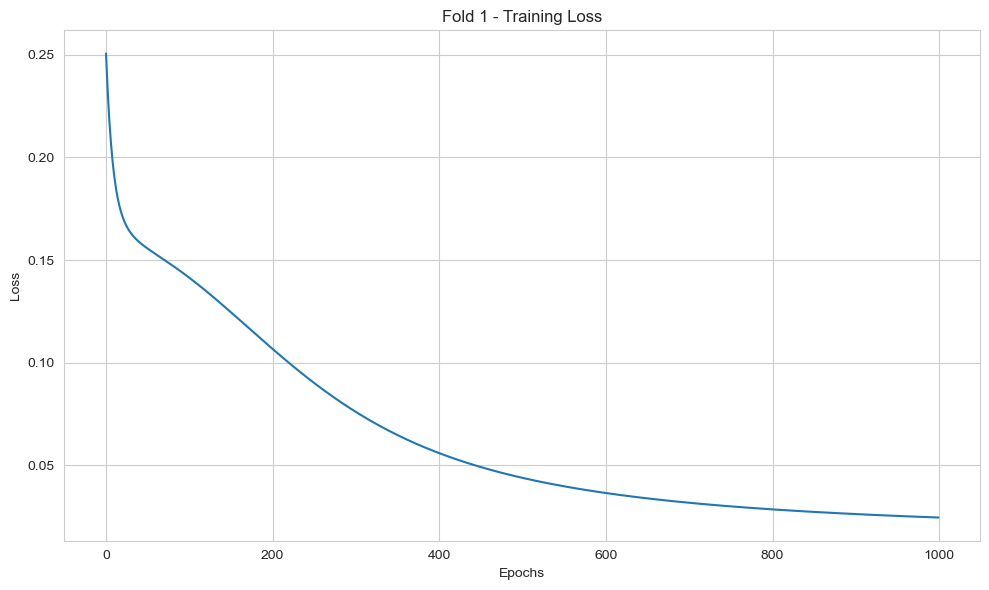

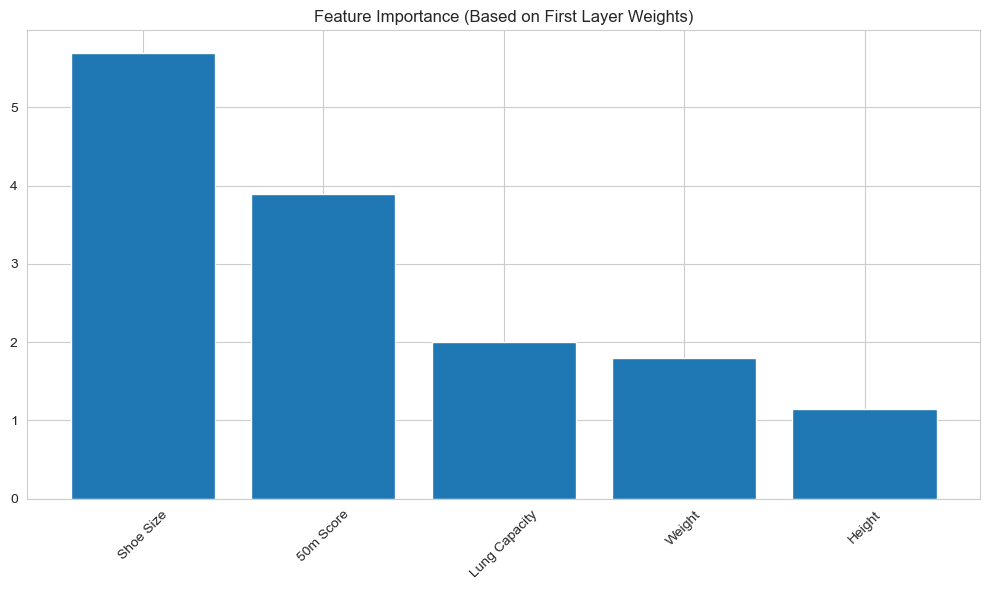

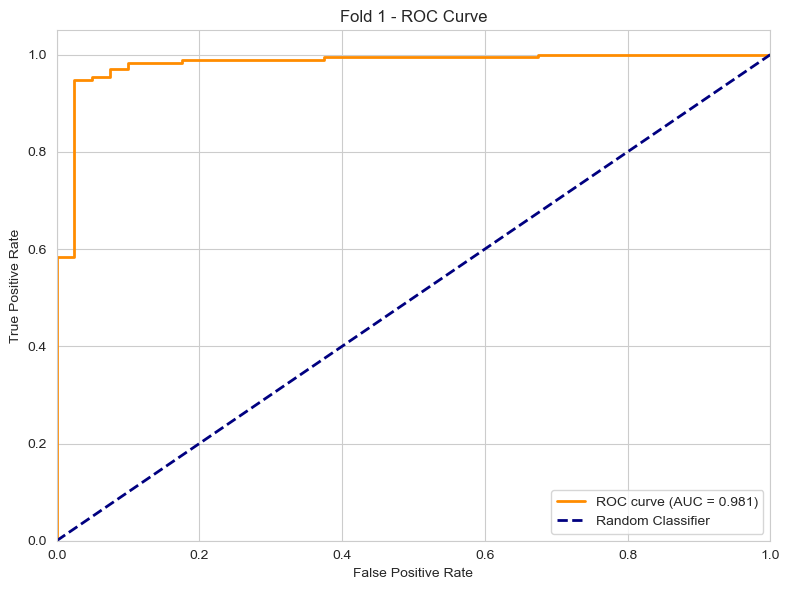

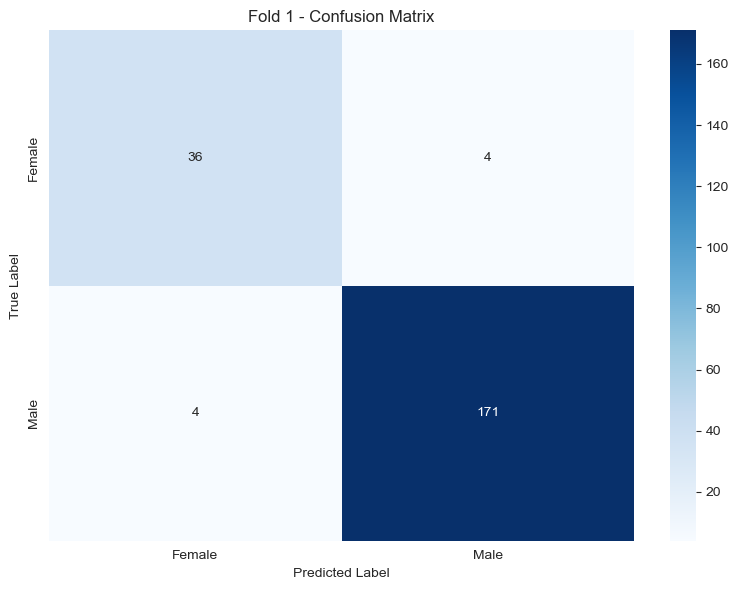

Fold 1 Results: SE=0.977, SP=0.900, ACC=0.963, AUC=0.981

Processing Fold 2...
Epoch 0, Loss: 0.2478
Epoch 200, Loss: 0.1043
Epoch 400, Loss: 0.0589
Epoch 600, Loss: 0.0409
Epoch 800, Loss: 0.0331


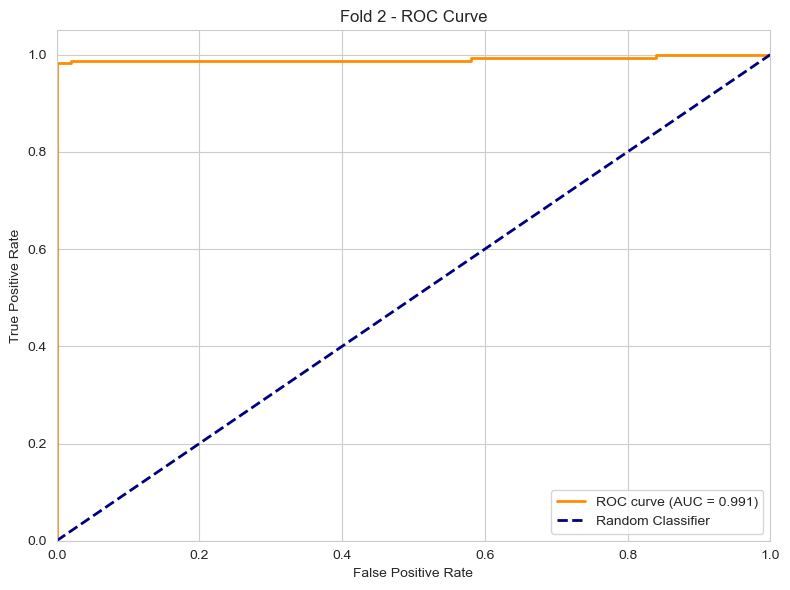

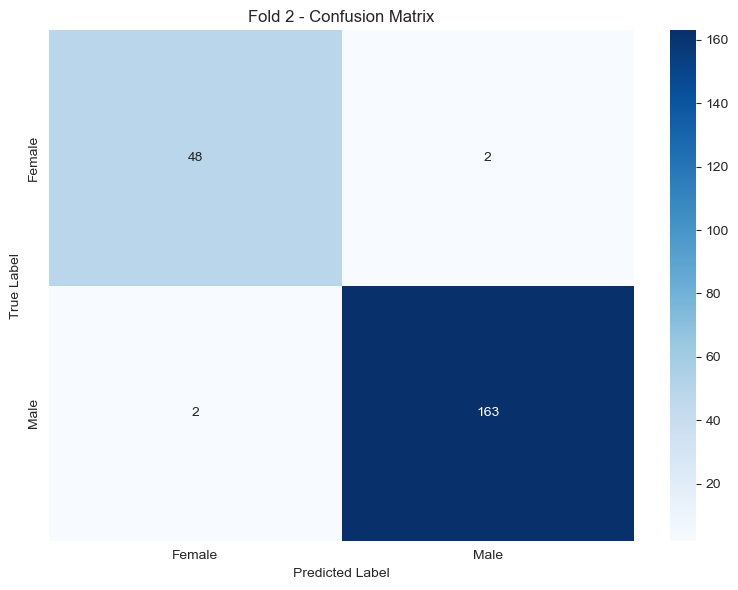

Fold 2 Results: SE=0.988, SP=0.960, ACC=0.981, AUC=0.991

Processing Fold 3...
Epoch 0, Loss: 0.2487
Epoch 200, Loss: 0.1064
Epoch 400, Loss: 0.0573
Epoch 600, Loss: 0.0387
Epoch 800, Loss: 0.0310


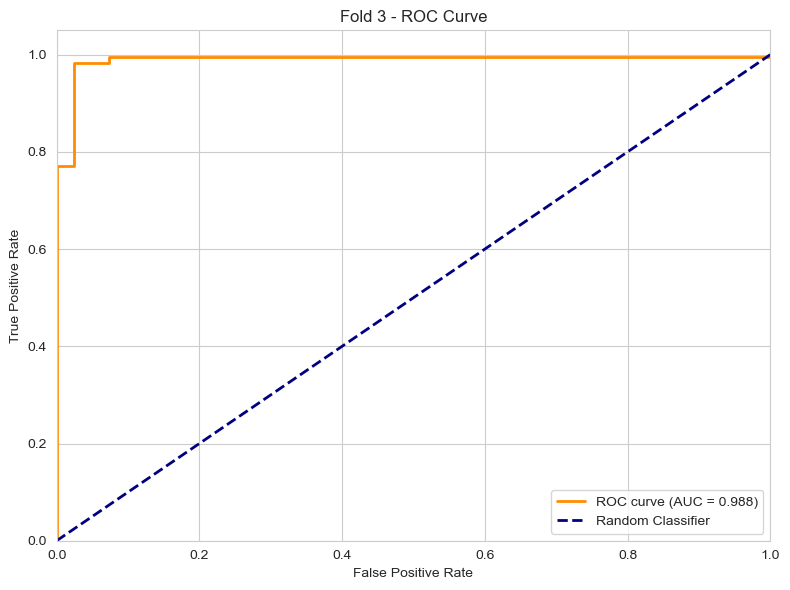

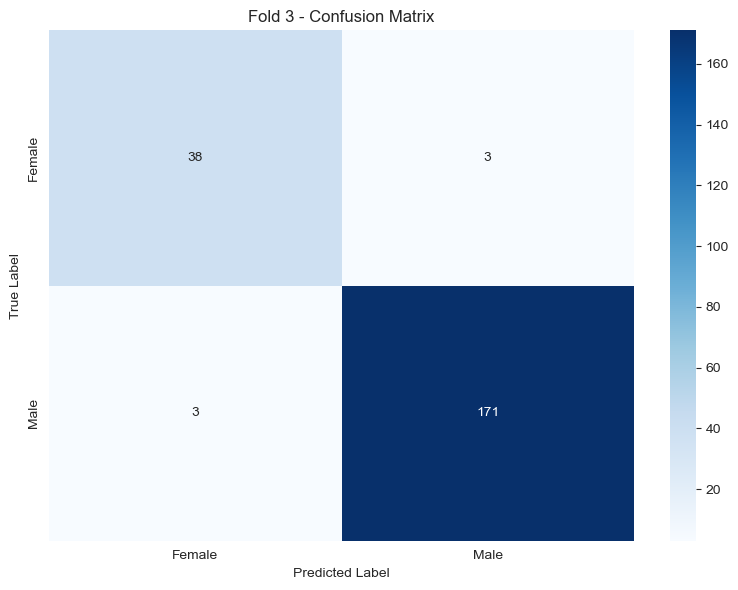

Fold 3 Results: SE=0.983, SP=0.927, ACC=0.972, AUC=0.988

Processing Fold 4...
Epoch 0, Loss: 0.2514
Epoch 200, Loss: 0.1038
Epoch 400, Loss: 0.0561
Epoch 600, Loss: 0.0376
Epoch 800, Loss: 0.0298


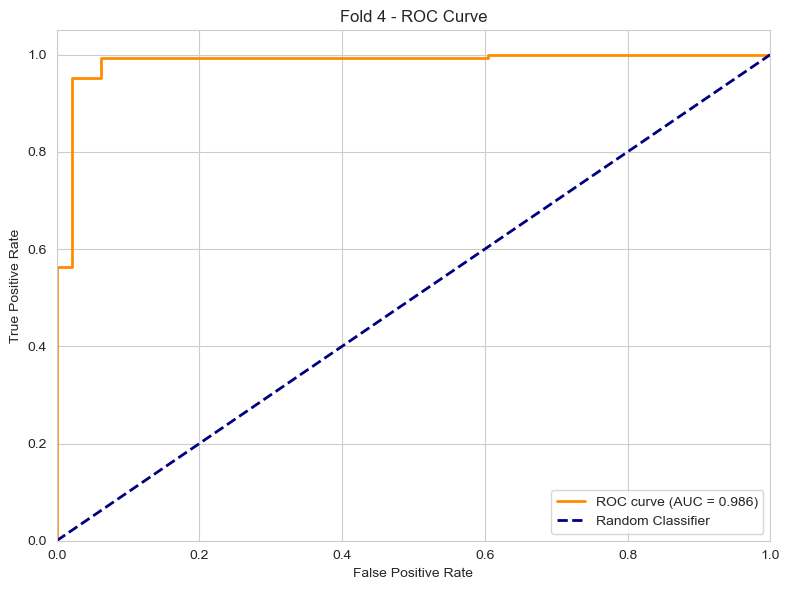

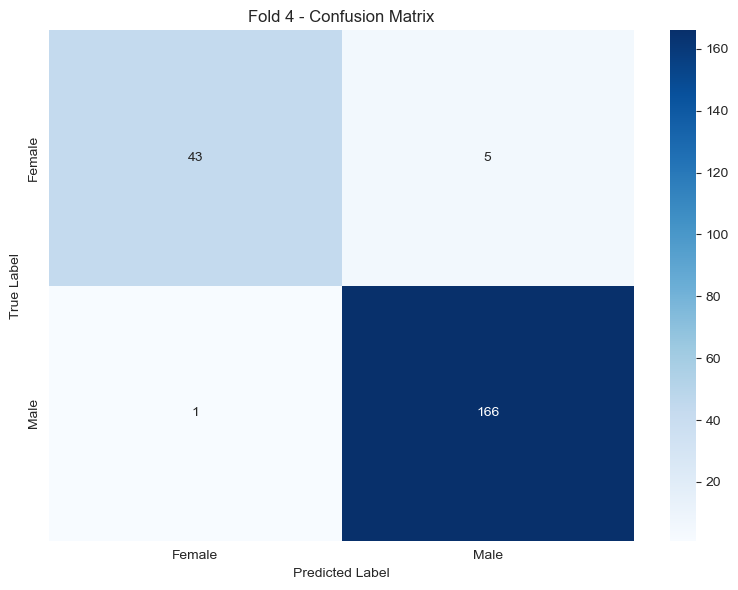

Fold 4 Results: SE=0.994, SP=0.896, ACC=0.972, AUC=0.986

Processing Fold 5...
Epoch 0, Loss: 0.2495
Epoch 200, Loss: 0.1097
Epoch 400, Loss: 0.0599
Epoch 600, Loss: 0.0413
Epoch 800, Loss: 0.0335


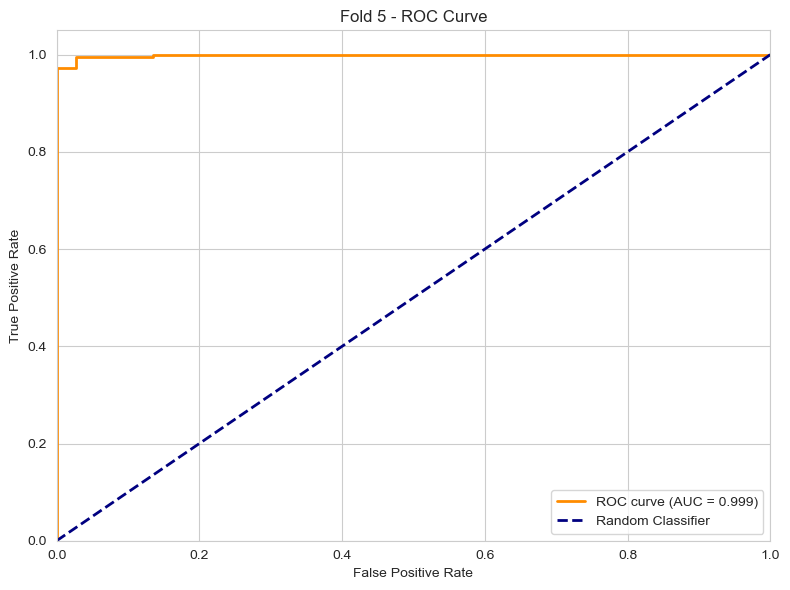

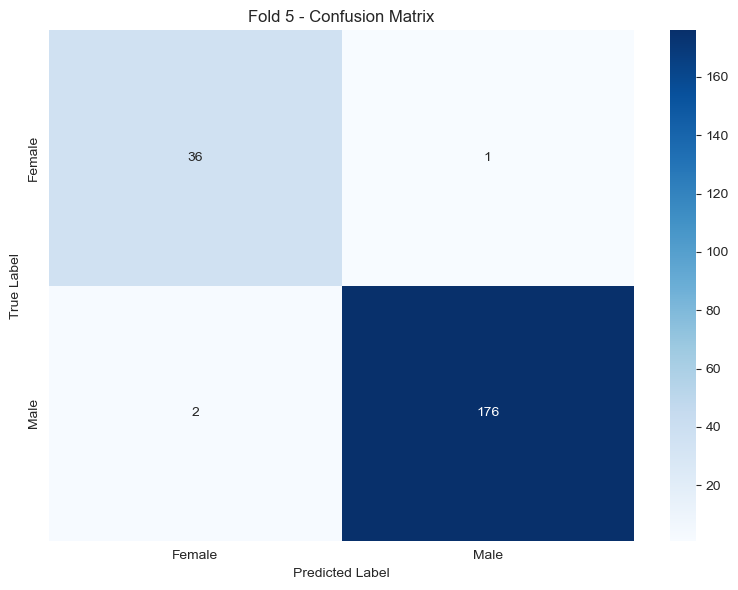

Fold 5 Results: SE=0.989, SP=0.973, ACC=0.986, AUC=0.999

MLP Model Performance (5-Fold Cross Validation Average)
SE       SP       ACC      AUC     
------------------------------------------------------------
0.986   0.931   0.975   0.989
------------------------------------------------------------


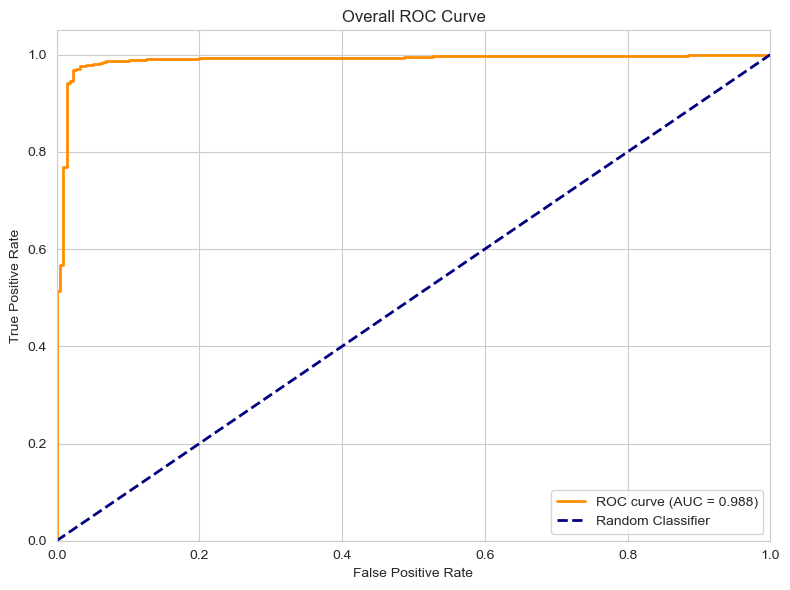

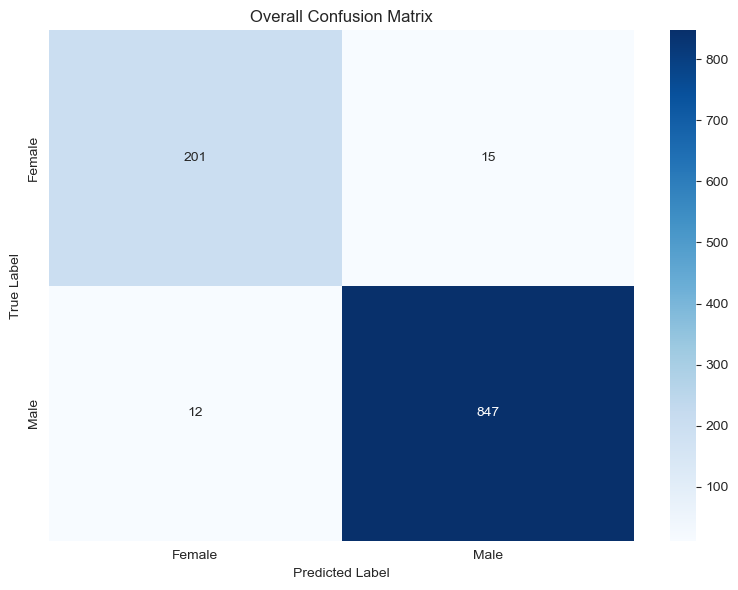

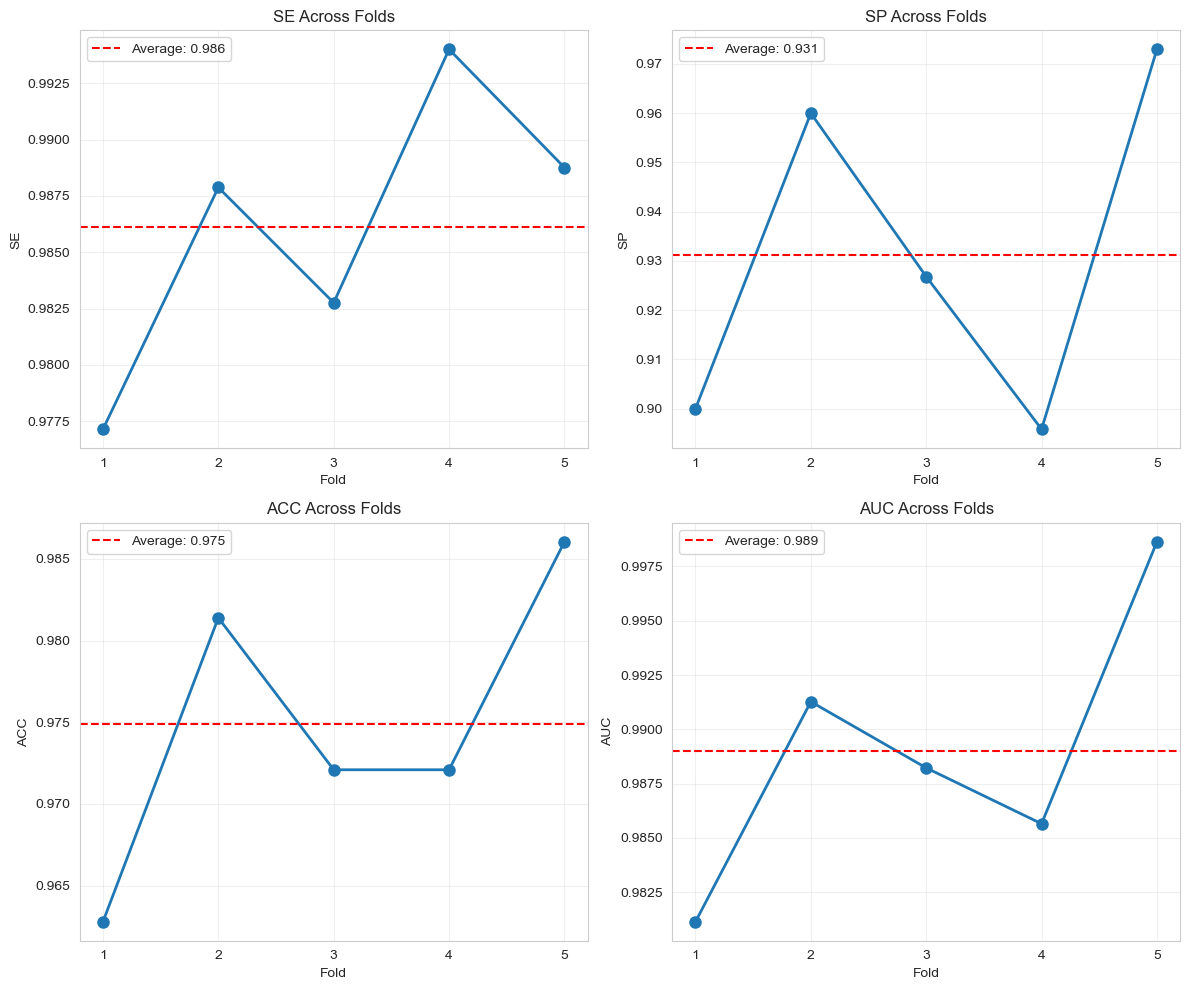

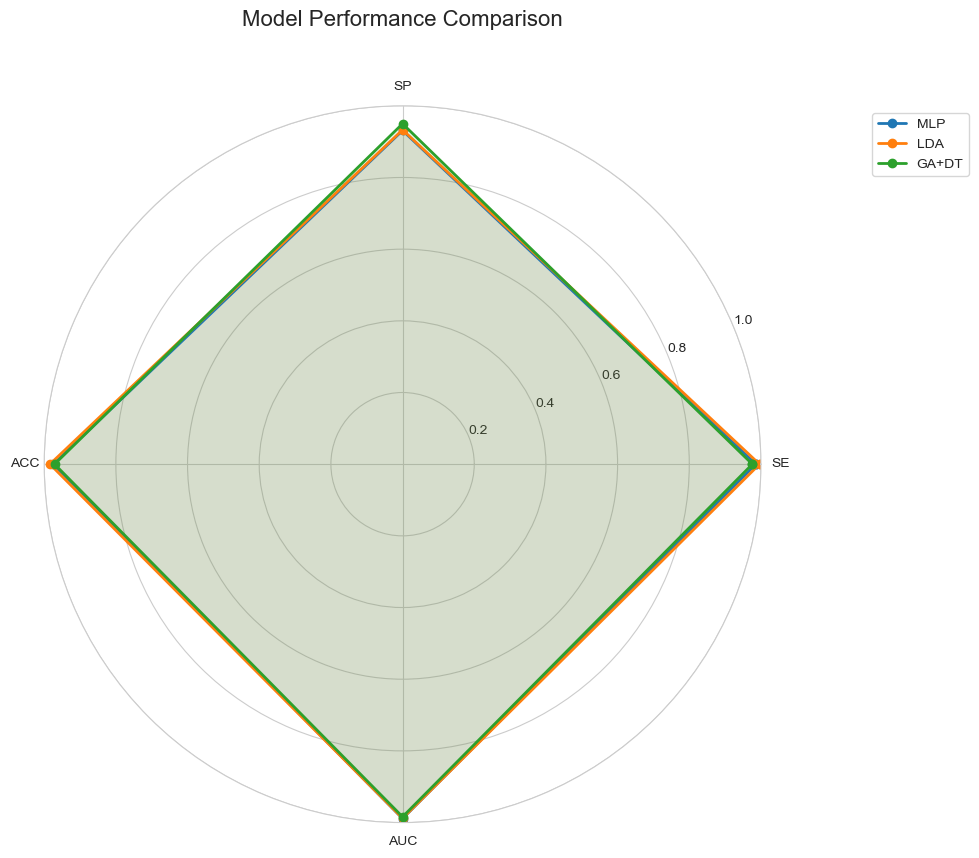

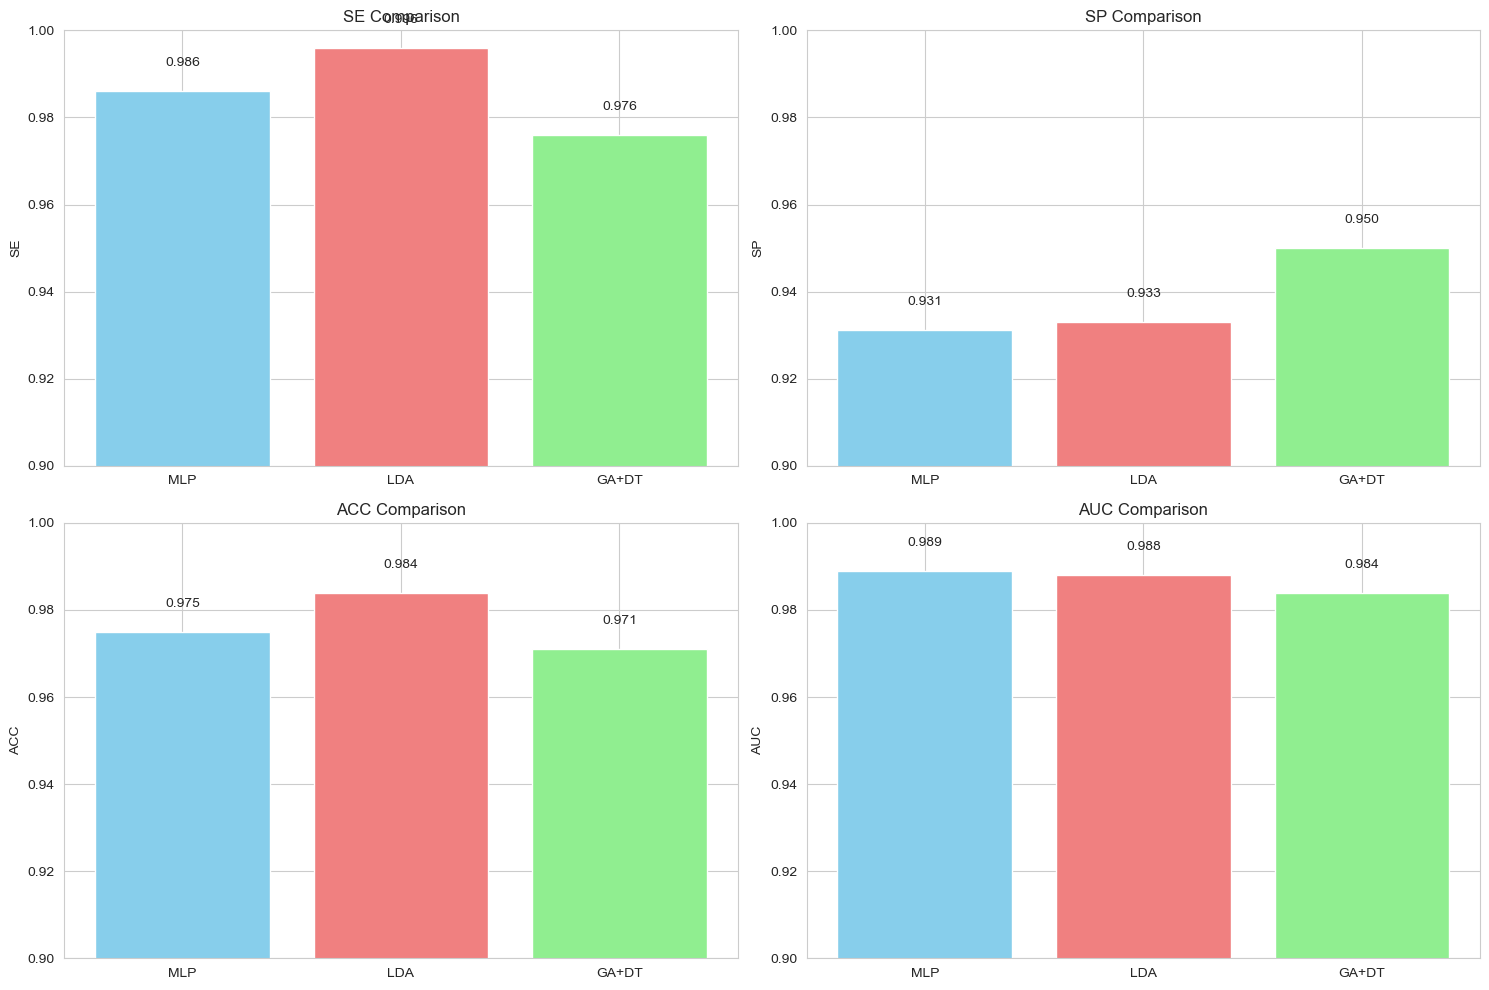


Detailed Results:
  Fold 1: SE=0.977, SP=0.900, ACC=0.963, AUC=0.981
  Fold 2: SE=0.988, SP=0.960, ACC=0.981, AUC=0.991
  Fold 3: SE=0.983, SP=0.927, ACC=0.972, AUC=0.988
  Fold 4: SE=0.994, SP=0.896, ACC=0.972, AUC=0.986
  Fold 5: SE=0.989, SP=0.973, ACC=0.986, AUC=0.999

Comparison with Reference Results
Model      SE       SP       ACC      AUC     
------------------------------------------------------------
MLP        0.986   0.931   0.975   0.989
LDA        0.996    0.933    0.984    0.988
GA+DT      0.976    0.950    0.971    0.984
------------------------------------------------------------


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 设置图形样式和字体
plt.rcParams['font.family'] = 'DejaVu Sans'  # 使用系统默认字体，避免中文问题
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # 初始化权重和偏置
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))
        
        # 记录训练损失
        self.loss_history = []
    
    def sigmoid(self, x):
        # 确保x是浮点数
        x = x.astype(np.float64)
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, X):
        # 确保输入是浮点数
        X = X.astype(np.float64)
        # 前向传播
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, output):
        # 反向传播
        m = X.shape[0]
        
        # 输出层误差
        dZ2 = output - y.reshape(-1, 1)
        dW2 = (1/m) * np.dot(self.a1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        # 隐藏层误差
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        # 更新参数
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        
        return np.mean(dZ2**2)
    
    def train(self, X, y, epochs=1000):
        # 确保输入是浮点数
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        
        self.loss_history = []
        for i in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            self.loss_history.append(loss)
            
            if i % 200 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")
    
    def predict(self, X):
        X = X.astype(np.float64)
        output = self.forward(X)
        return (output > 0.5).astype(int).flatten()
    
    def predict_proba(self, X):
        X = X.astype(np.float64)
        return self.forward(X).flatten()

def evaluate_model(y_true, y_pred, y_proba):
    """评估模型性能"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    SE = tp / (tp + fn)  # 灵敏度
    SP = tn / (tn + fp)  # 特异度
    ACC = (tp + tn) / (tp + tn + fp + fn)  # 准确率
    AUC = roc_auc_score(y_true, y_proba)  # AUC
    
    return SE, SP, ACC, AUC

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Female', 'Male'], 
                yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_proba, title="ROC Curve"):
    """绘制ROC曲线"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_training_loss(loss_history, title="Training Loss"):
    """绘制训练损失变化"""
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(X, model, feature_names):
    """绘制特征重要性"""
    # 使用第一层权重的绝对值之和作为特征重要性
    importance = np.sum(np.abs(model.W1), axis=1)
    
    plt.figure(figsize=(10, 6))
    indices = np.argsort(importance)[::-1]
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
    plt.title('Feature Importance (Based on First Layer Weights)')
    plt.tight_layout()
    plt.show()

def plot_performance_comparison(mlp_results, lda_results, dt_results):
    """绘制性能比较图"""
    models = ['MLP', 'LDA', 'GA+DT']
    metrics = ['SE', 'SP', 'ACC', 'AUC']
    
    # MLP结果
    mlp_avg = np.mean(mlp_results, axis=0)
    
    # 第三次作业结果
    lda_ref = [0.996, 0.933, 0.984, 0.988]
    dt_ref = [0.976, 0.950, 0.971, 0.984]
    
    # 创建数据
    data = {
        'MLP': mlp_avg,
        'LDA': lda_ref,
        'GA+DT': dt_ref
    }
    
    # 绘制雷达图
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # 闭合雷达图
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for model, values in data.items():
        values = np.array(values).tolist()
        values += values[:1]  # 闭合雷达图
        ax.plot(angles, values, 'o-', linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)
    ax.set_title('Model Performance Comparison', size=16, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    plt.show()
    
    # 绘制柱状图比较
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        values = [data[model][i] for model in models]
        bars = axes[i].bar(models, values, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].set_ylim(0.9, 1.0)
        
        # 在柱子上添加数值
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_cross_validation_results(mlp_results):
    """绘制交叉验证结果"""
    metrics = ['SE', 'SP', 'ACC', 'AUC']
    folds = range(1, len(mlp_results) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        values = [result[i] for result in mlp_results]
        axes[i].plot(folds, values, 'o-', linewidth=2, markersize=8)
        axes[i].set_title(f'{metric} Across Folds')
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(folds)
        axes[i].grid(True, alpha=0.3)
        
        # 添加平均值线
        avg_value = np.mean(values)
        axes[i].axhline(y=avg_value, color='r', linestyle='--', 
                       label=f'Average: {avg_value:.3f}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # 读取数据
    df = pd.read_excel('2025-模式识别作业数据集汇总-.xlsx')
    
    # 选择特征和目标变量
    features = ['身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量']
    feature_names = ['Height', 'Weight', 'Shoe Size', '50m Score', 'Lung Capacity']
    target = '性别 男1女0'
    
    # 数据预处理
    X = df[features].copy()
    y = df[target].copy()
    
    # 处理缺失值
    X = X.fillna(X.mean())
    
    # 处理异常值（如性别为0.5的情况）
    y = y.apply(lambda x: 1 if x == 0.5 else x)  # 将0.5转为1
    
    # 确保所有数据都是数值型
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    # 再次处理缺失值（如果有的话）
    X = X.fillna(X.mean())
    y = y.fillna(1)  # 假设缺失的性别为男性
    
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=features)
    
    # 确保数据是浮点数
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    
    print("Data preprocessing completed!")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Male proportion: {y.mean():.2%}")
    print(f"Female proportion: {1 - y.mean():.2%}")
    
    # 5折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 存储MLP结果
    mlp_results = []
    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    
    fold = 1
    for train_idx, test_idx in kf.split(X):
        print(f"\nProcessing Fold {fold}...")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # MLP模型
        mlp = MLP(input_size=5, hidden_size=5, output_size=1, learning_rate=0.1)
        mlp.train(X_train.values, y_train.values, epochs=1000)
        
        y_pred_mlp = mlp.predict(X_test.values)
        y_proba_mlp = mlp.predict_proba(X_test.values)
        mlp_se, mlp_sp, mlp_acc, mlp_auc = evaluate_model(y_test.values, y_pred_mlp, y_proba_mlp)
        mlp_results.append([mlp_se, mlp_sp, mlp_acc, mlp_auc])
        
        # 收集所有预测结果
        all_y_true.extend(y_test.values)
        all_y_pred.extend(y_pred_mlp)
        all_y_proba.extend(y_proba_mlp)
        
        # 绘制第一折的训练损失
        if fold == 1:
            plot_training_loss(mlp.loss_history, f"Fold {fold} - Training Loss")
            plot_feature_importance(X, mlp, feature_names)
        
        # 绘制每一折的ROC曲线
        plot_roc_curve(y_test.values, y_proba_mlp, f"Fold {fold} - ROC Curve")
        
        # 绘制每一折的混淆矩阵
        plot_confusion_matrix(y_test.values, y_pred_mlp, f"Fold {fold} - Confusion Matrix")
        
        print(f"Fold {fold} Results: SE={mlp_se:.3f}, SP={mlp_sp:.3f}, ACC={mlp_acc:.3f}, AUC={mlp_auc:.3f}")
        
        fold += 1
    
    # 计算平均性能
    mlp_avg = np.mean(mlp_results, axis=0)
    
    # 输出结果
    print("\n" + "="*60)
    print("MLP Model Performance (5-Fold Cross Validation Average)")
    print("="*60)
    print(f"{'SE':<8} {'SP':<8} {'ACC':<8} {'AUC':<8}")
    print("-"*60)
    print(f"{mlp_avg[0]:.3f}   {mlp_avg[1]:.3f}   {mlp_avg[2]:.3f}   {mlp_avg[3]:.3f}")
    print("-"*60)
    
    # 绘制总体ROC曲线
    plot_roc_curve(all_y_true, all_y_proba, "Overall ROC Curve")
    
    # 绘制总体混淆矩阵
    plot_confusion_matrix(all_y_true, all_y_pred, "Overall Confusion Matrix")
    
    # 绘制交叉验证结果
    plot_cross_validation_results(mlp_results)
    
    # 与第三次作业结果比较
    lda_results = [[0.996, 0.933, 0.984, 0.988]]
    dt_results = [[0.976, 0.950, 0.971, 0.984]]
    plot_performance_comparison(mlp_results, lda_results, dt_results)
    
    # 输出详细结果
    print("\nDetailed Results:")
    for i, result in enumerate(mlp_results, 1):
        print(f"  Fold {i}: SE={result[0]:.3f}, SP={result[1]:.3f}, ACC={result[2]:.3f}, AUC={result[3]:.3f}")
    
    # 输出与参考结果的比较
    print("\n" + "="*60)
    print("Comparison with Reference Results")
    print("="*60)
    print(f"{'Model':<10} {'SE':<8} {'SP':<8} {'ACC':<8} {'AUC':<8}")
    print("-"*60)
    print(f"{'MLP':<10} {mlp_avg[0]:.3f}   {mlp_avg[1]:.3f}   {mlp_avg[2]:.3f}   {mlp_avg[3]:.3f}")
    print(f"{'LDA':<10} 0.996    0.933    0.984    0.988")
    print(f"{'GA+DT':<10} 0.976    0.950    0.971    0.984")
    print("-"*60)

if __name__ == "__main__":
    main()

结果将保存到目录: MLP_Results_20251118_184645
Data preprocessing completed!
Number of features: 5
Number of samples: 1075
Male proportion: 79.91%
Female proportion: 20.09%

Processing Fold 1...
Epoch 0, Loss: 0.2474
Epoch 200, Loss: 0.1068
Epoch 400, Loss: 0.0560
Epoch 600, Loss: 0.0366
Epoch 800, Loss: 0.0286
训练损失图已保存: MLP_Results_20251118_184645\images\fold_1_training_loss.png


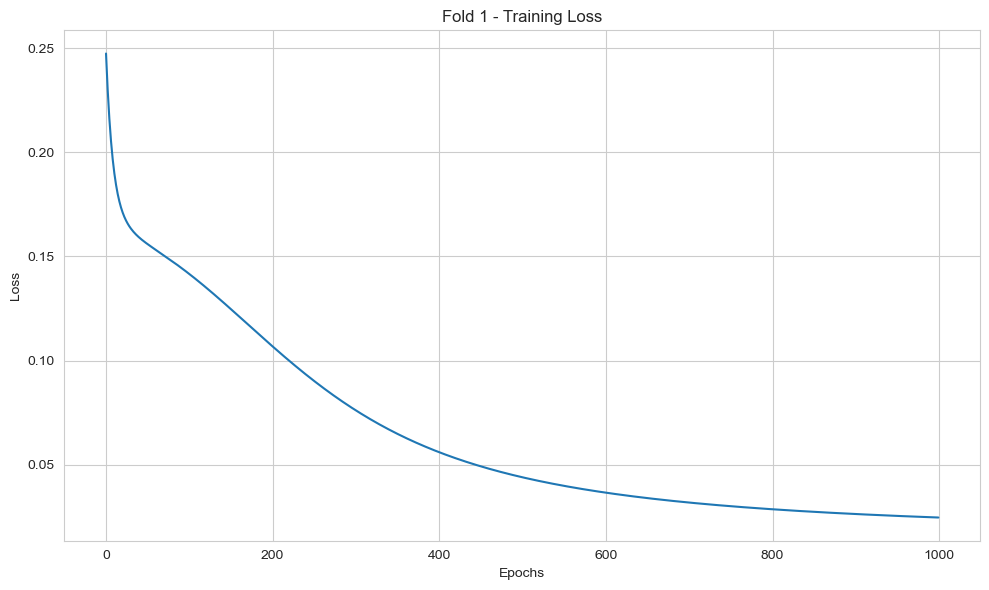

特征重要性图已保存: MLP_Results_20251118_184645\images\fold_1_feature_importance.png


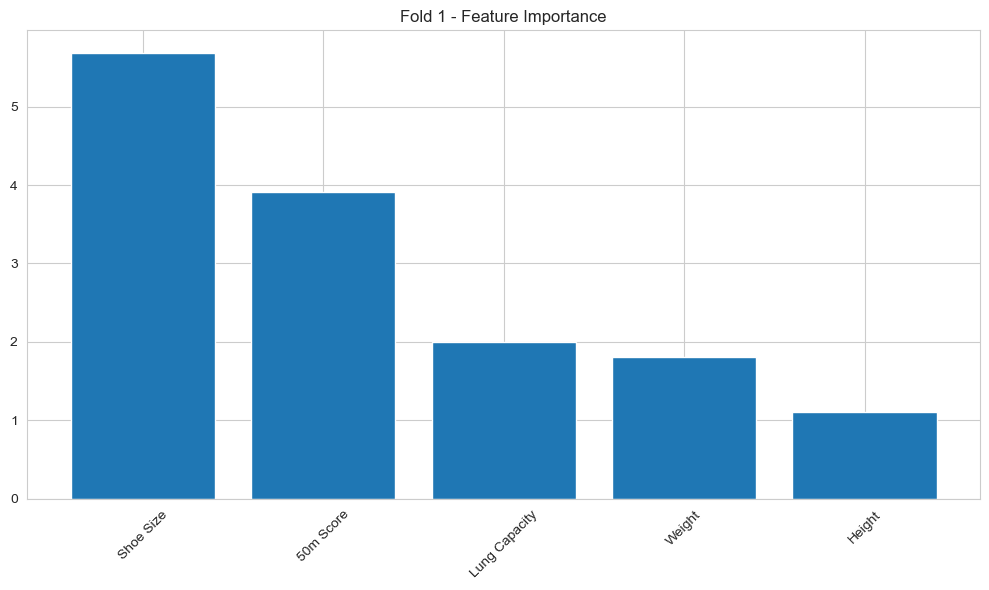

ROC曲线已保存: MLP_Results_20251118_184645\images\fold_1_roc_curve.png


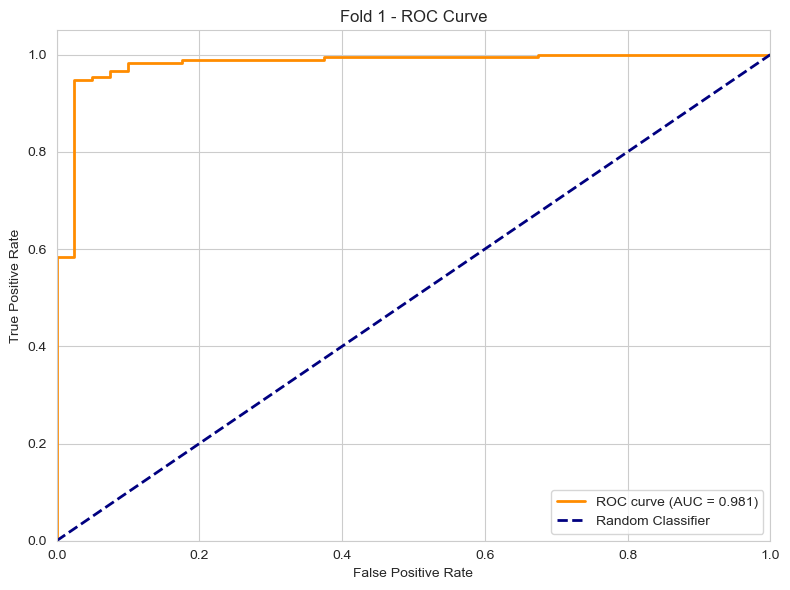

混淆矩阵已保存: MLP_Results_20251118_184645\images\fold_1_confusion_matrix.png


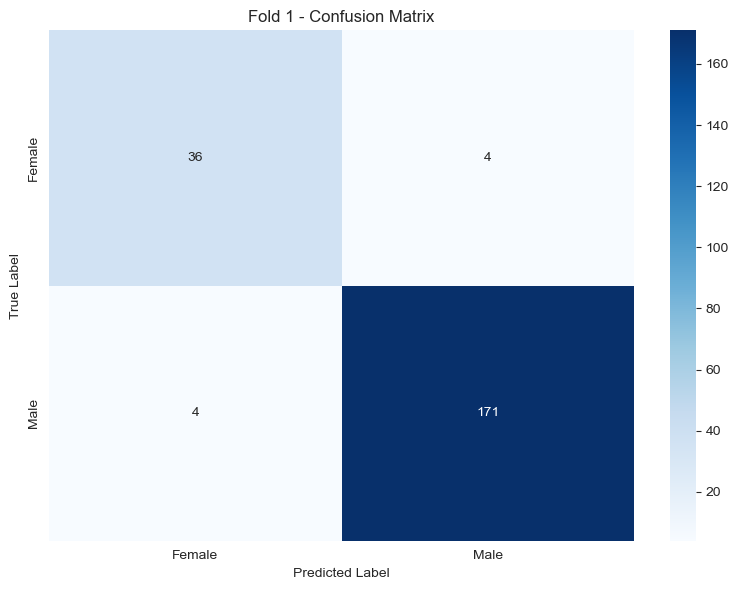

Fold 1 Results: SE=0.977, SP=0.900, ACC=0.963, AUC=0.981

Processing Fold 2...
Epoch 0, Loss: 0.2482
Epoch 200, Loss: 0.1051
Epoch 400, Loss: 0.0593
Epoch 600, Loss: 0.0410
Epoch 800, Loss: 0.0332
ROC曲线已保存: MLP_Results_20251118_184645\images\fold_2_roc_curve.png


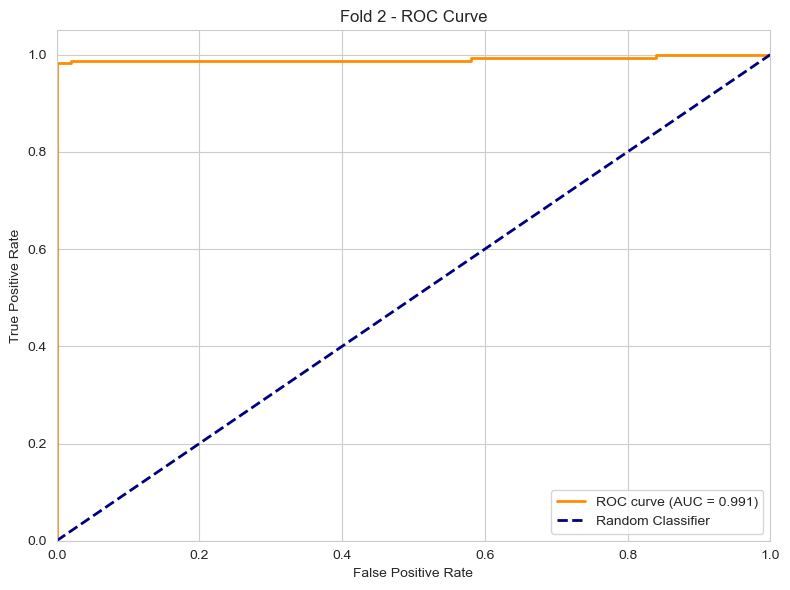

混淆矩阵已保存: MLP_Results_20251118_184645\images\fold_2_confusion_matrix.png


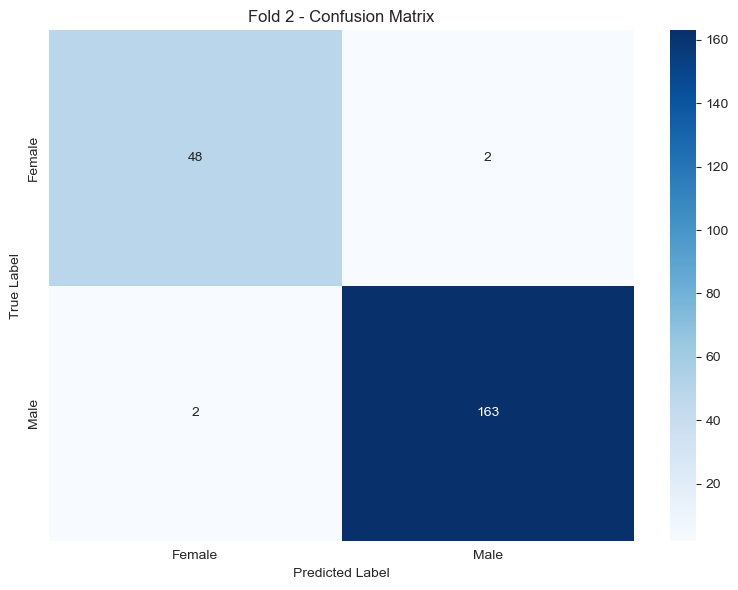

Fold 2 Results: SE=0.988, SP=0.960, ACC=0.981, AUC=0.991

Processing Fold 3...
Epoch 0, Loss: 0.2476
Epoch 200, Loss: 0.1070
Epoch 400, Loss: 0.0576
Epoch 600, Loss: 0.0389
Epoch 800, Loss: 0.0311
ROC曲线已保存: MLP_Results_20251118_184645\images\fold_3_roc_curve.png


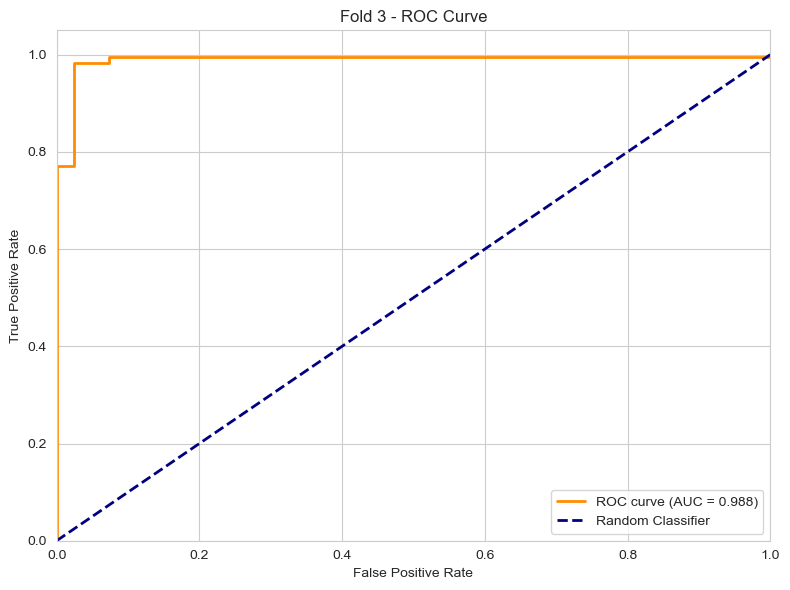

混淆矩阵已保存: MLP_Results_20251118_184645\images\fold_3_confusion_matrix.png


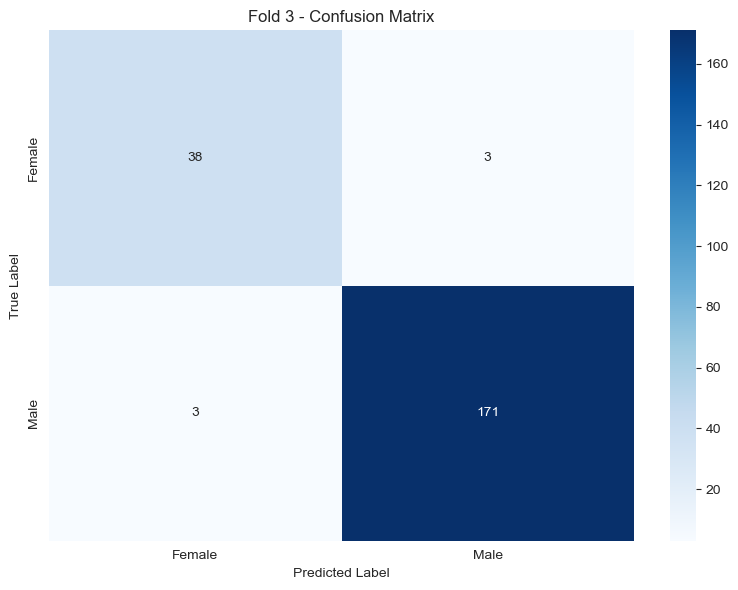

Fold 3 Results: SE=0.983, SP=0.927, ACC=0.972, AUC=0.988

Processing Fold 4...
Epoch 0, Loss: 0.2480
Epoch 200, Loss: 0.1028
Epoch 400, Loss: 0.0557
Epoch 600, Loss: 0.0375
Epoch 800, Loss: 0.0297
ROC曲线已保存: MLP_Results_20251118_184645\images\fold_4_roc_curve.png


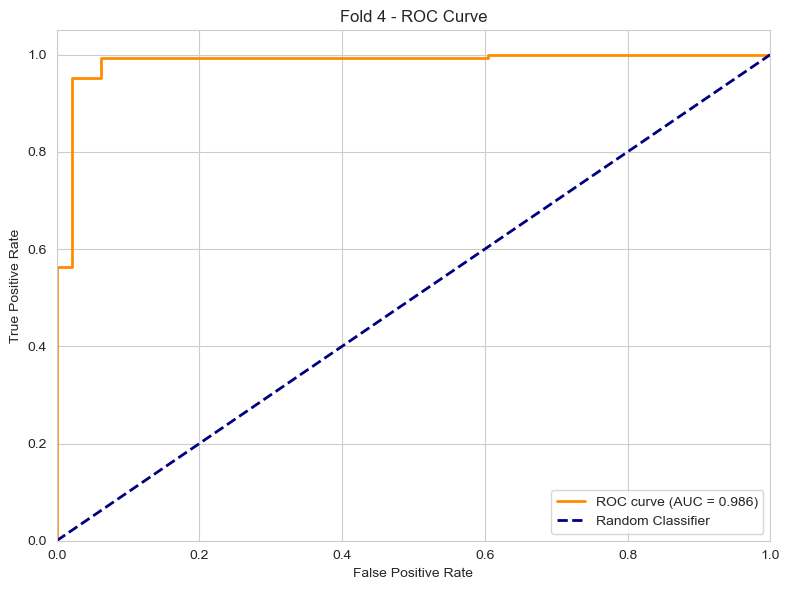

混淆矩阵已保存: MLP_Results_20251118_184645\images\fold_4_confusion_matrix.png


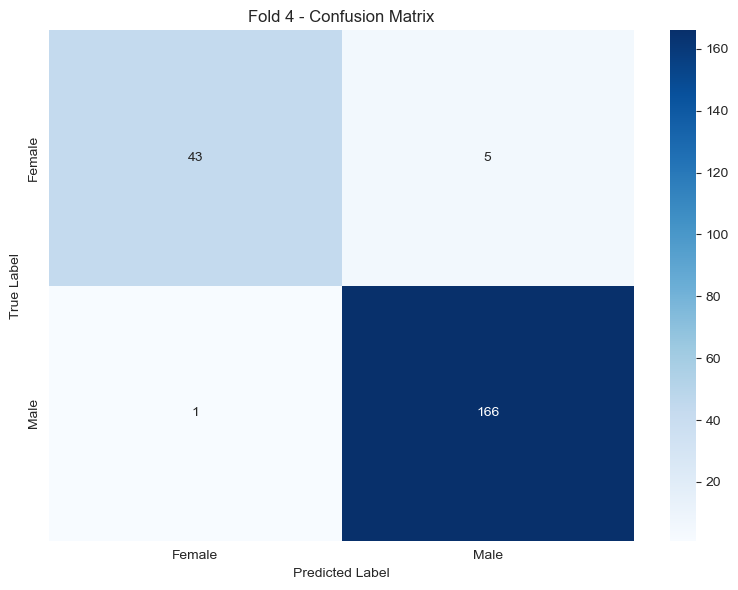

Fold 4 Results: SE=0.994, SP=0.896, ACC=0.972, AUC=0.986

Processing Fold 5...
Epoch 0, Loss: 0.2484
Epoch 200, Loss: 0.1093
Epoch 400, Loss: 0.0597
Epoch 600, Loss: 0.0412
Epoch 800, Loss: 0.0334
ROC曲线已保存: MLP_Results_20251118_184645\images\fold_5_roc_curve.png


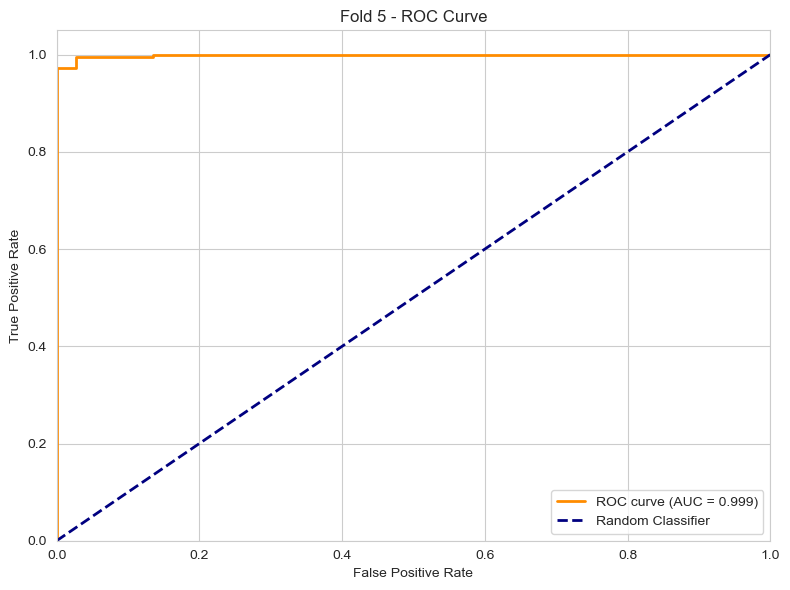

混淆矩阵已保存: MLP_Results_20251118_184645\images\fold_5_confusion_matrix.png


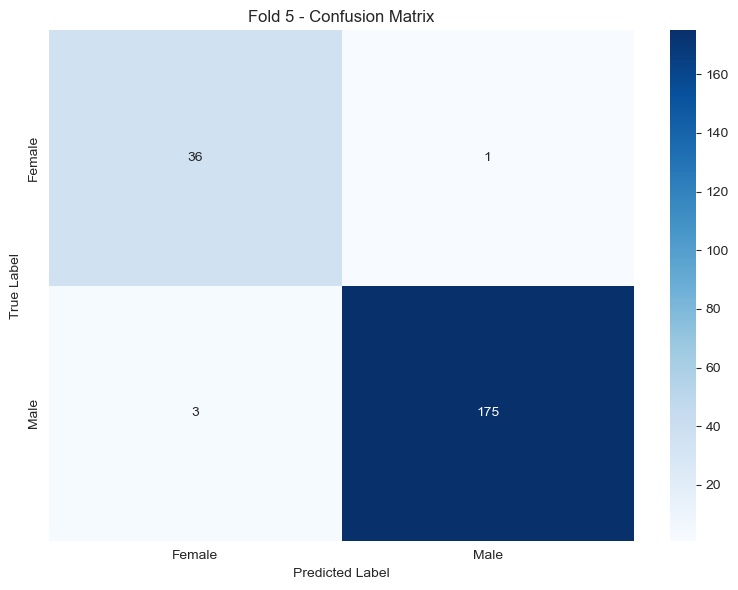

Fold 5 Results: SE=0.983, SP=0.973, ACC=0.981, AUC=0.999

MLP Model Performance (5-Fold Cross Validation Average)
SE       SP       ACC      AUC     
------------------------------------------------------------
0.985   0.931   0.974   0.989
------------------------------------------------------------
ROC曲线已保存: MLP_Results_20251118_184645\images\overall_roc_curve.png


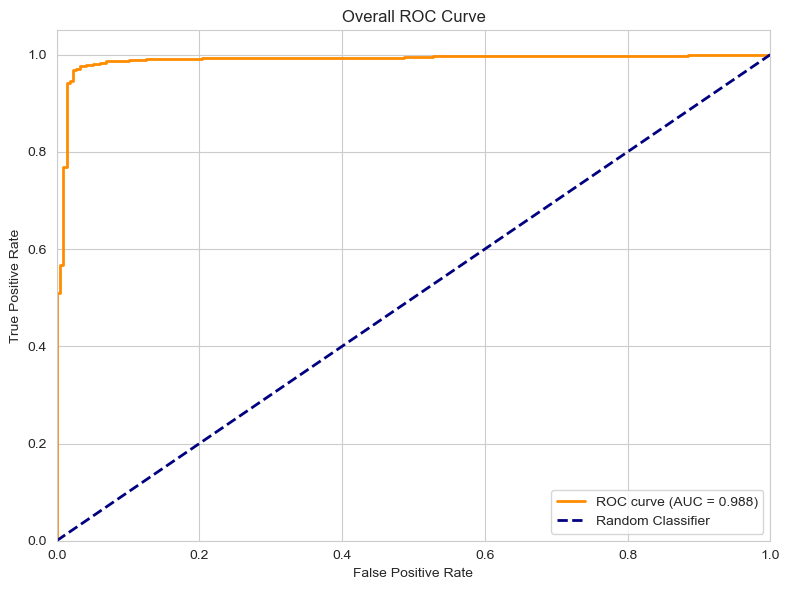

混淆矩阵已保存: MLP_Results_20251118_184645\images\overall_confusion_matrix.png


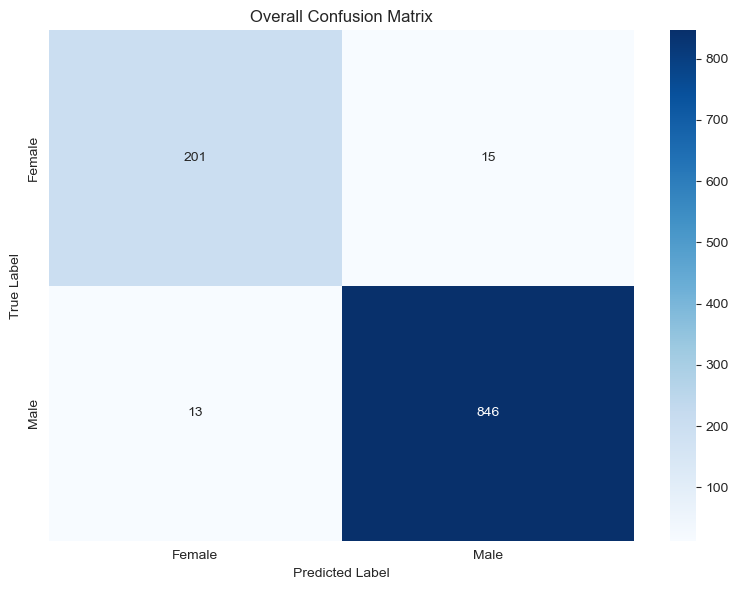

交叉验证结果图已保存: MLP_Results_20251118_184645\images\cross_validation_results.png


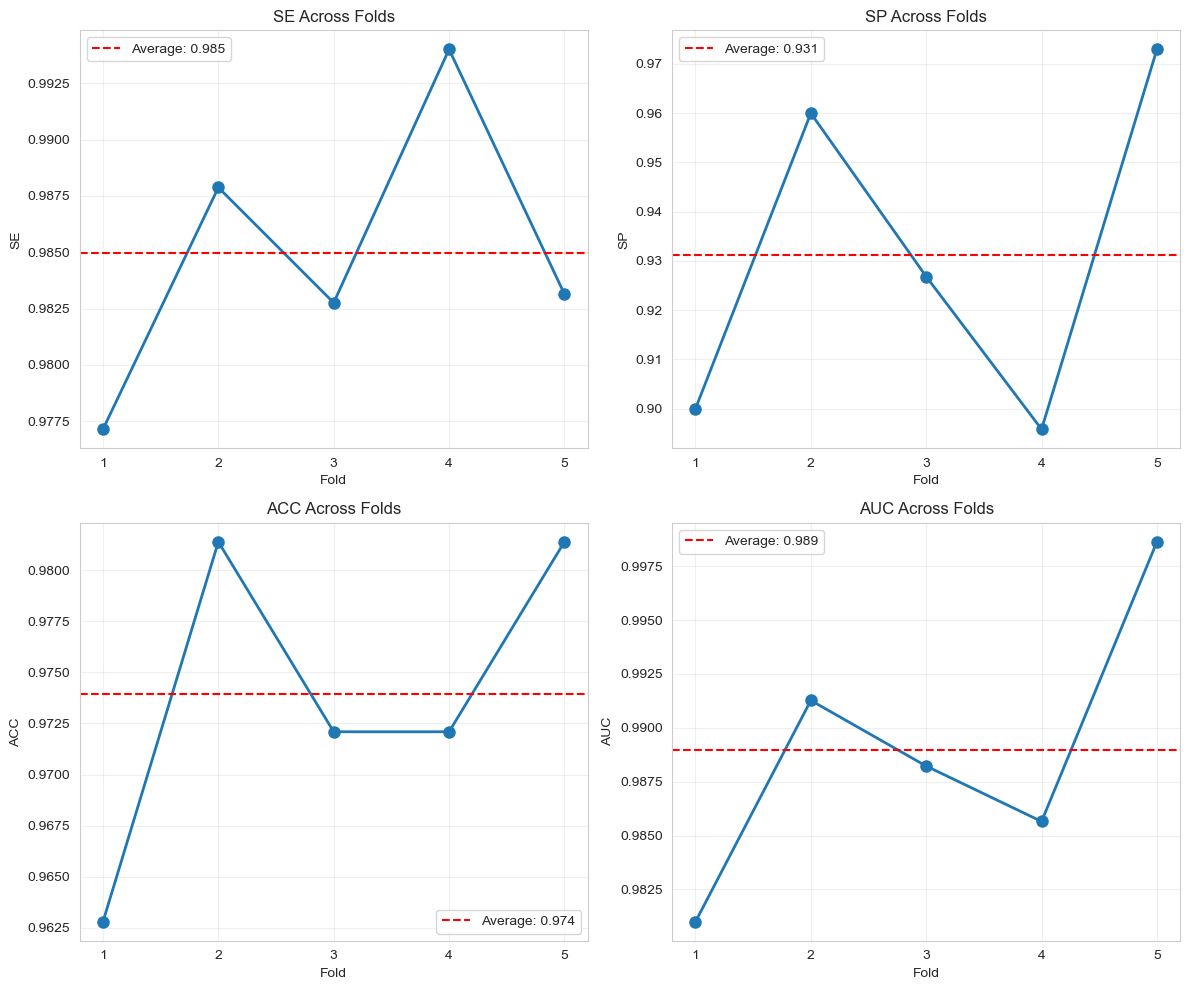

性能比较图已保存: MLP_Results_20251118_184645\images\model_comparison.png


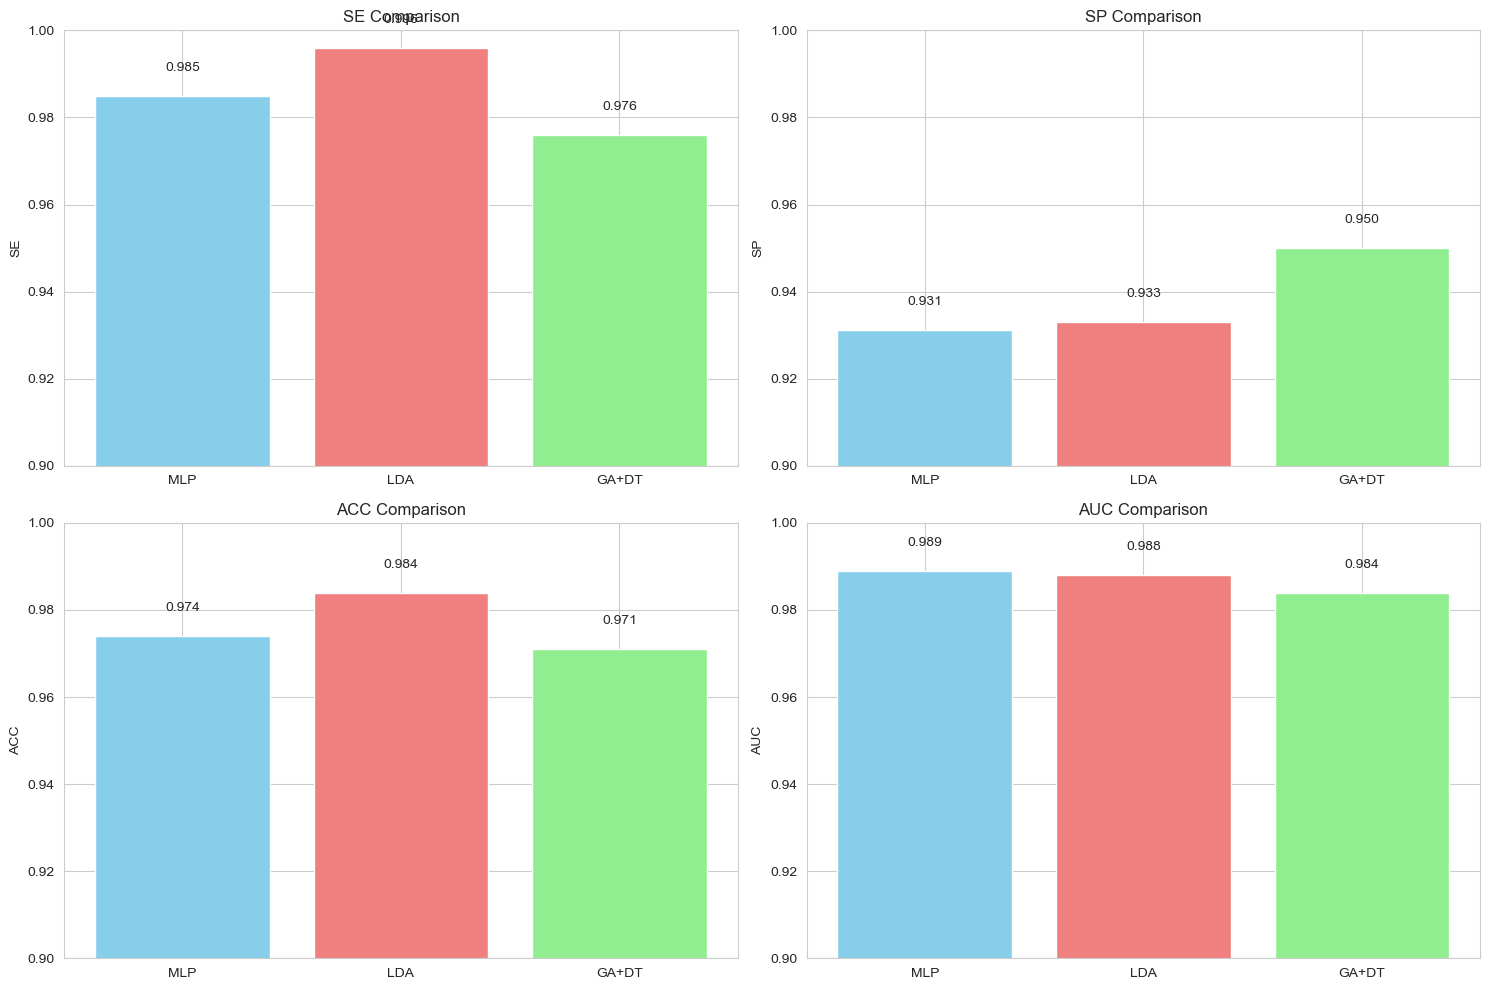

雷达图已保存: MLP_Results_20251118_184645\images\model_comparison_radar.png


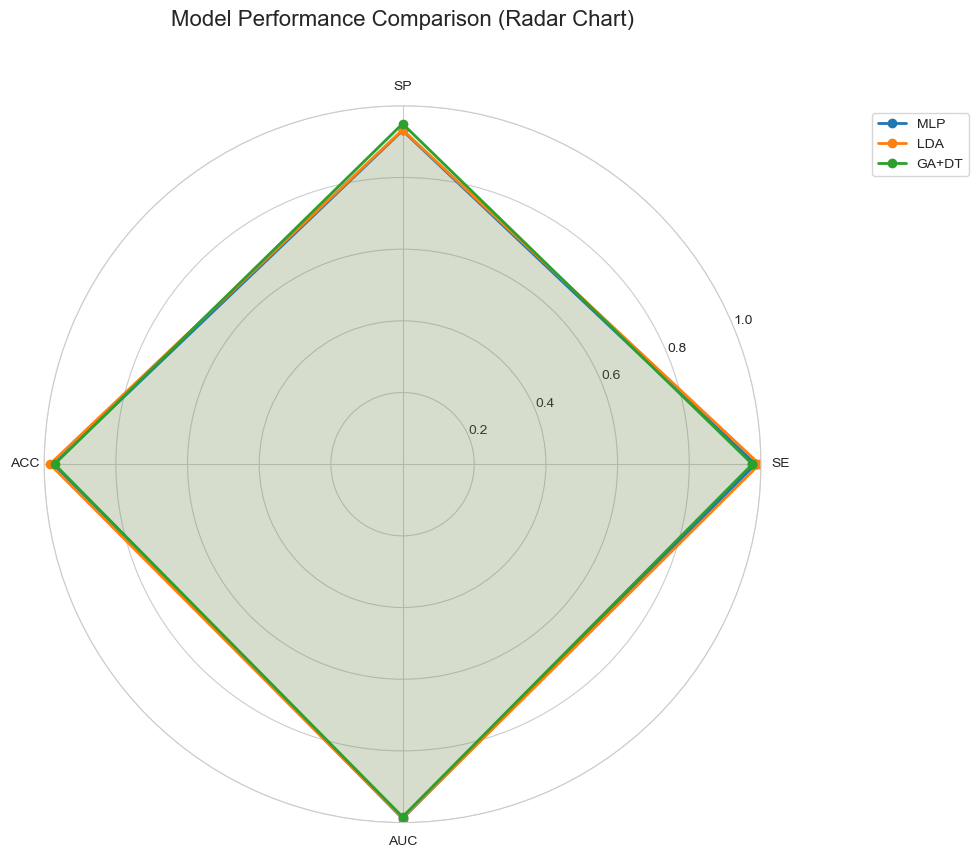

结果已保存到文件: MLP_Results_20251118_184645\detailed_results.txt

Detailed Results:
  Fold 1: SE=0.977, SP=0.900, ACC=0.963, AUC=0.981
  Fold 2: SE=0.988, SP=0.960, ACC=0.981, AUC=0.991
  Fold 3: SE=0.983, SP=0.927, ACC=0.972, AUC=0.988
  Fold 4: SE=0.994, SP=0.896, ACC=0.972, AUC=0.986
  Fold 5: SE=0.983, SP=0.973, ACC=0.981, AUC=0.999

Comparison with Reference Results
Model      SE       SP       ACC      AUC     
------------------------------------------------------------
MLP        0.985   0.931   0.974   0.989
LDA        0.996    0.933    0.984    0.988
GA+DT      0.976    0.950    0.971    0.984
------------------------------------------------------------

所有结果已保存到目录: MLP_Results_20251118_184645
包含 16 张图片和 1 个详细结果文件


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置图形样式和字体
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # 初始化权重和偏置
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))
        
        # 记录训练损失
        self.loss_history = []
    
    def sigmoid(self, x):
        x = x.astype(np.float64)
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, X):
        X = X.astype(np.float64)
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, output):
        m = X.shape[0]
        
        # 输出层误差
        dZ2 = output - y.reshape(-1, 1)
        dW2 = (1/m) * np.dot(self.a1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        # 隐藏层误差
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        # 更新参数
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        
        return np.mean(dZ2**2)
    
    def train(self, X, y, epochs=1000):
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        
        self.loss_history = []
        for i in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            self.loss_history.append(loss)
            
            if i % 200 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")
    
    def predict(self, X):
        X = X.astype(np.float64)
        output = self.forward(X)
        return (output > 0.5).astype(int).flatten()
    
    def predict_proba(self, X):
        X = X.astype(np.float64)
        return self.forward(X).flatten()

def evaluate_model(y_true, y_pred, y_proba):
    """评估模型性能"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    SE = tp / (tp + fn)  # 灵敏度
    SP = tn / (tn + fp)  # 特异度
    ACC = (tp + tn) / (tp + tn + fp + fn)  # 准确率
    AUC = roc_auc_score(y_true, y_proba)  # AUC
    
    return SE, SP, ACC, AUC

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", save_path=None):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Female', 'Male'], 
                yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"混淆矩阵已保存: {save_path}")
    plt.show()

def plot_roc_curve(y_true, y_proba, title="ROC Curve", save_path=None):
    """绘制ROC曲线"""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROC曲线已保存: {save_path}")
    plt.show()

def plot_training_loss(loss_history, title="Training Loss", save_path=None):
    """绘制训练损失变化"""
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"训练损失图已保存: {save_path}")
    plt.show()

def plot_feature_importance(X, model, feature_names, title="Feature Importance", save_path=None):
    """绘制特征重要性"""
    importance = np.sum(np.abs(model.W1), axis=1)
    
    plt.figure(figsize=(10, 6))
    indices = np.argsort(importance)[::-1]
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
    plt.title(title)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"特征重要性图已保存: {save_path}")
    plt.show()

def plot_performance_comparison(mlp_results, lda_results, dt_results, save_path=None):
    """绘制性能比较图"""
    models = ['MLP', 'LDA', 'GA+DT']
    metrics = ['SE', 'SP', 'ACC', 'AUC']
    
    # MLP结果
    mlp_avg = np.mean(mlp_results, axis=0)
    
    # 第三次作业结果
    lda_ref = [0.996, 0.933, 0.984, 0.988]
    dt_ref = [0.976, 0.950, 0.971, 0.984]
    
    # 创建数据
    data = {
        'MLP': mlp_avg,
        'LDA': lda_ref,
        'GA+DT': dt_ref
    }
    
    # 绘制柱状图比较
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        values = [data[model][i] for model in models]
        bars = axes[i].bar(models, values, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].set_ylim(0.9, 1.0)
        
        # 在柱子上添加数值
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"性能比较图已保存: {save_path}")
    plt.show()
    
    # 绘制雷达图（单独绘制，避免极坐标问题）
    plot_radar_chart(data, metrics, save_path=save_path.replace('.png', '_radar.png') if save_path else None)

def plot_radar_chart(data, metrics, save_path=None):
    """绘制雷达图"""
    # 修正雷达图绘制
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # 闭合雷达图
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for model, values in data.items():
        values = np.array(values).tolist()
        values += values[:1]  # 闭合雷达图
        ax.plot(angles, values, 'o-', linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # 修复：使用正确的方法设置角度网格
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title('Model Performance Comparison (Radar Chart)', size=16, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"雷达图已保存: {save_path}")
    plt.show()

def plot_cross_validation_results(mlp_results, save_path=None):
    """绘制交叉验证结果"""
    metrics = ['SE', 'SP', 'ACC', 'AUC']
    folds = range(1, len(mlp_results) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        values = [result[i] for result in mlp_results]
        axes[i].plot(folds, values, 'o-', linewidth=2, markersize=8)
        axes[i].set_title(f'{metric} Across Folds')
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(folds)
        axes[i].grid(True, alpha=0.3)
        
        # 添加平均值线
        avg_value = np.mean(values)
        axes[i].axhline(y=avg_value, color='r', linestyle='--', 
                       label=f'Average: {avg_value:.3f}')
        axes[i].legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"交叉验证结果图已保存: {save_path}")
    plt.show()

def save_results_to_file(results, file_path):
    """保存结果到文本文件"""
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write("="*60 + "\n")
        f.write("MLP Gender Classification Results\n")
        f.write("="*60 + "\n\n")
        
        f.write("MODEL PERFORMANCE (5-Fold Cross Validation)\n")
        f.write("-"*50 + "\n")
        f.write(f"{'Fold':<6} {'SE':<8} {'SP':<8} {'ACC':<8} {'AUC':<8}\n")
        f.write("-"*50 + "\n")
        
        for i, result in enumerate(results['mlp_results'], 1):
            f.write(f"{i:<6} {result[0]:<8.3f} {result[1]:<8.3f} {result[2]:<8.3f} {result[3]:<8.3f}\n")
        
        f.write("-"*50 + "\n")
        f.write(f"{'Average':<6} {results['mlp_avg'][0]:<8.3f} {results['mlp_avg'][1]:<8.3f} {results['mlp_avg'][2]:<8.3f} {results['mlp_avg'][3]:<8.3f}\n\n")
        
        f.write("COMPARISON WITH REFERENCE MODELS\n")
        f.write("-"*50 + "\n")
        f.write(f"{'Model':<10} {'SE':<8} {'SP':<8} {'ACC':<8} {'AUC':<8}\n")
        f.write("-"*50 + "\n")
        f.write(f"{'MLP':<10} {results['mlp_avg'][0]:<8.3f} {results['mlp_avg'][1]:<8.3f} {results['mlp_avg'][2]:<8.3f} {results['mlp_avg'][3]:<8.3f}\n")
        f.write(f"{'LDA':<10} 0.996    0.933    0.984    0.988\n")
        f.write(f"{'GA+DT':<10} 0.976    0.950    0.971    0.984\n\n")
        
        f.write("DATA INFORMATION\n")
        f.write("-"*50 + "\n")
        f.write(f"Number of samples: {results['data_info']['n_samples']}\n")
        f.write(f"Number of features: {results['data_info']['n_features']}\n")
        f.write(f"Male proportion: {results['data_info']['male_proportion']:.2%}\n")
        f.write(f"Female proportion: {results['data_info']['female_proportion']:.2%}\n\n")
        
        f.write("EXECUTION INFORMATION\n")
        f.write("-"*50 + "\n")
        f.write(f"Execution time: {results['execution_info']['timestamp']}\n")
        f.write(f"Total folds: {results['execution_info']['total_folds']}\n")
    
    print(f"结果已保存到文件: {file_path}")

def main():
    # 创建结果保存目录
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = f"MLP_Results_{timestamp}"
    images_dir = os.path.join(results_dir, "images")
    
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)
    
    print(f"结果将保存到目录: {results_dir}")
    
    # 读取数据
    df = pd.read_excel('2025-模式识别作业数据集汇总-.xlsx')
    
    # 选择特征和目标变量
    features = ['身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量']
    feature_names = ['Height', 'Weight', 'Shoe Size', '50m Score', 'Lung Capacity']
    target = '性别 男1女0'
    
    # 数据预处理
    X = df[features].copy()
    y = df[target].copy()
    
    # 处理缺失值
    X = X.fillna(X.mean())
    
    # 处理异常值
    y = y.apply(lambda x: 1 if x == 0.5 else x)
    
    # 确保所有数据都是数值型
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    # 再次处理缺失值
    X = X.fillna(X.mean())
    y = y.fillna(1)
    
    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=features)
    
    # 确保数据是浮点数
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    
    print("Data preprocessing completed!")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Male proportion: {y.mean():.2%}")
    print(f"Female proportion: {1 - y.mean():.2%}")
    
    # 存储数据信息
    data_info = {
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'male_proportion': y.mean(),
        'female_proportion': 1 - y.mean()
    }
    
    # 5折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 存储MLP结果
    mlp_results = []
    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    
    fold = 1
    for train_idx, test_idx in kf.split(X):
        print(f"\nProcessing Fold {fold}...")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # MLP模型
        mlp = MLP(input_size=5, hidden_size=5, output_size=1, learning_rate=0.1)
        mlp.train(X_train.values, y_train.values, epochs=1000)
        
        y_pred_mlp = mlp.predict(X_test.values)
        y_proba_mlp = mlp.predict_proba(X_test.values)
        mlp_se, mlp_sp, mlp_acc, mlp_auc = evaluate_model(y_test.values, y_pred_mlp, y_proba_mlp)
        mlp_results.append([mlp_se, mlp_sp, mlp_acc, mlp_auc])
        
        # 收集所有预测结果
        all_y_true.extend(y_test.values)
        all_y_pred.extend(y_pred_mlp)
        all_y_proba.extend(y_proba_mlp)
        
        # 绘制并保存第一折的图表
        if fold == 1:
            plot_training_loss(
                mlp.loss_history, 
                f"Fold {fold} - Training Loss",
                save_path=os.path.join(images_dir, f"fold_{fold}_training_loss.png")
            )
            plot_feature_importance(
                X, mlp, feature_names,
                f"Fold {fold} - Feature Importance",
                save_path=os.path.join(images_dir, f"fold_{fold}_feature_importance.png")
            )
        
        # 绘制并保存每一折的ROC曲线和混淆矩阵
        plot_roc_curve(
            y_test.values, y_proba_mlp, 
            f"Fold {fold} - ROC Curve",
            save_path=os.path.join(images_dir, f"fold_{fold}_roc_curve.png")
        )
        
        plot_confusion_matrix(
            y_test.values, y_pred_mlp, 
            f"Fold {fold} - Confusion Matrix",
            save_path=os.path.join(images_dir, f"fold_{fold}_confusion_matrix.png")
        )
        
        print(f"Fold {fold} Results: SE={mlp_se:.3f}, SP={mlp_sp:.3f}, ACC={mlp_acc:.3f}, AUC={mlp_auc:.3f}")
        
        fold += 1
    
    # 计算平均性能
    mlp_avg = np.mean(mlp_results, axis=0)
    
    # 输出结果到控制台
    print("\n" + "="*60)
    print("MLP Model Performance (5-Fold Cross Validation Average)")
    print("="*60)
    print(f"{'SE':<8} {'SP':<8} {'ACC':<8} {'AUC':<8}")
    print("-"*60)
    print(f"{mlp_avg[0]:.3f}   {mlp_avg[1]:.3f}   {mlp_avg[2]:.3f}   {mlp_avg[3]:.3f}")
    print("-"*60)
    
    # 绘制并保存总体图表
    plot_roc_curve(
        all_y_true, all_y_proba, 
        "Overall ROC Curve",
        save_path=os.path.join(images_dir, "overall_roc_curve.png")
    )
    
    plot_confusion_matrix(
        all_y_true, all_y_pred, 
        "Overall Confusion Matrix",
        save_path=os.path.join(images_dir, "overall_confusion_matrix.png")
    )
    
    plot_cross_validation_results(
        mlp_results,
        save_path=os.path.join(images_dir, "cross_validation_results.png")
    )
    
    # 与第三次作业结果比较
    lda_results = [[0.996, 0.933, 0.984, 0.988]]
    dt_results = [[0.976, 0.950, 0.971, 0.984]]
    plot_performance_comparison(
        mlp_results, lda_results, dt_results,
        save_path=os.path.join(images_dir, "model_comparison.png")
    )
    
    # 保存详细结果到文件
    results_data = {
        'mlp_results': mlp_results,
        'mlp_avg': mlp_avg,
        'data_info': data_info,
        'execution_info': {
            'timestamp': timestamp,
            'total_folds': len(mlp_results)
        }
    }
    
    save_results_to_file(
        results_data, 
        os.path.join(results_dir, "detailed_results.txt")
    )
    
    # 输出详细结果到控制台
    print("\nDetailed Results:")
    for i, result in enumerate(mlp_results, 1):
        print(f"  Fold {i}: SE={result[0]:.3f}, SP={result[1]:.3f}, ACC={result[2]:.3f}, AUC={result[3]:.3f}")
    
    # 输出与参考结果的比较
    print("\n" + "="*60)
    print("Comparison with Reference Results")
    print("="*60)
    print(f"{'Model':<10} {'SE':<8} {'SP':<8} {'ACC':<8} {'AUC':<8}")
    print("-"*60)
    print(f"{'MLP':<10} {mlp_avg[0]:.3f}   {mlp_avg[1]:.3f}   {mlp_avg[2]:.3f}   {mlp_avg[3]:.3f}")
    print(f"{'LDA':<10} 0.996    0.933    0.984    0.988")
    print(f"{'GA+DT':<10} 0.976    0.950    0.971    0.984")
    print("-"*60)
    
    print(f"\n所有结果已保存到目录: {results_dir}")
    print(f"包含 {len(mlp_results) * 2 + 6} 张图片和 1 个详细结果文件")

if __name__ == "__main__":
    main()